## Agricultural pest recognition with image data

## Table of Content

1. [Executive Summary](#cell_Summary)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Predictive Modeling](#cell_model)

4. [Experiments Report](#cell_report)



<a id = "cell_Summary"></a>
## 1. Executive Summary

**Problem Definition:**
The project involves developing and evaluating machine learning models for pest detection in agricultural settings, using a dataset containing 2,479 real images of five different types of agricultural pests: Ants, Bees, Grasshoppers, Moths, and Wasps.

The objective of this project is to enhance pest recognition models for effective deployment in practical agricultural environments.

**Proposed Approaches:**
- Two deep learning models with different architectures utilizing Convolutional Neural Networks (CNN) techniques are created and compared for classifying these pest images.
- Key experiments focus on hyperparameter tuning (filters, dense layers, kernel size), image quality, optimizer selection (RMSprop, Adam, Adadelta), loss function (categorical_crossentropy, huber), and other model configurations.

**Major Findings:**
1. Parameter Optimization:
The optimization process involved a meticulous exploration of model parameters to enhance pest detection in agricultural settings. Key findings shed light on the pivotal choices in model configuration. Notably, experiments demonstrated that increasing the number of filters beyond 32 did not substantially improve performance but risked overfitting. A kernel size of (1,1) emerged as a favorable choice, allowing the model to capture fine-grained patterns in the data. Additionally, it was observed that a smaller image size of (50,50,3) effectively balanced computational efficiency with the capacity to capture relevant features. The dense layer with 200 units displayed suitability for extracting high-level abstractions, although further fine-tuning may offer optimization opportunities. Furthermore, a dropout rate of 0.25 struck an optimal balance between regularization and model capacity. The selection of the categorical cross-entropy loss function and the RMSprop optimizer, with specific hyperparameter settings, contributed to model stability during training. Overall, these parameter optimization findings informed the development of a robust model for pest detection.

2. Model performance
Across all the experiments Model 1 (with above mentioned parameters) outperforms all others, achieving the highest accuracy (64%), substantial agreement (Kappa coefficient of 0.552), and a balanced F1-Score of 0.64. This indicates that Model 1 correctly classifies a significant portion of test samples while maintaining a good trade-off between minimizing false positives and false negatives.

3. Improving pest recognition models for agriculture is an ongoing process that requires a combination of data, technology, and domain knowledge, in accordance with following potential approaches:
- Data Quality: Collect diverse and representative data encompassing various crops, growth stages, lighting conditions, and pests for a robust model foundation.
- Accurate Labels: Ensure precise pest labeling to maximize model training effectiveness.
- Data Augmentation: Apply techniques like rotation, scaling, cropping, and flipping to expand the training dataset, reducing overfitting risks.
- Preprocessing: Employ noise reduction and image enhancement (contrast, brightness, sharpness adjustments) to improve image quality.
- Class Balance: Address class imbalances by oversampling minority classes or using focal loss to enhance detection of challenging pests.
- Continuous Learning: Implement systems for ongoing data updates to adapt to evolving pest populations and environmental changes.
- Iterative Improvement: Continually evaluate model performance in real-world agricultural scenarios and refine models based on feedback and emerging data trends.








<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

First, we import all required modules for this task

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tensorflow import keras
import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD, RMSprop, Adam, Nadam, Adadelta
from keras.losses import categorical_crossentropy
from keras.losses import huber

tf.config.list_physical_devices('GPU')

[]

After we upload images in the five folders to Google Drive. We create a folder named as `Part2_agricultural_pests` in Google Drive. Its target path should be "/My Drive/Part2_agricultural_pests".
Now, we can import those images on Google Colab by below codes:

In [2]:
from google.colab import drive
#it will open a webpage for verifying your google account. if it is successful, the Google colab can link the Google drive
drive.mount('/content/drive')

# to show the folders under the dataset
!ls "/content/drive/My Drive/Part2_agricultural_pests/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ants  bees  grasshopper  moth  wasp


We check the total number of files under ants, bees, grasshopper, moth and wasp folders respectively.

In [3]:
# Set the paths to the folders containing the image files
ants_path = '/content/drive/MyDrive/Part2_agricultural_pests/ants'
bees_path = '/content/drive/MyDrive/Part2_agricultural_pests/bees'
grasshopper_path = '/content/drive/MyDrive/Part2_agricultural_pests/grasshopper'
moth_path = '/content/drive/MyDrive/Part2_agricultural_pests/moth'
wasp_path = '/content/drive/MyDrive/Part2_agricultural_pests/wasp'


# get a list of all files in the folder
ants_file_list = os.listdir(ants_path)
bees_file_list = os.listdir(bees_path)
grasshopper_file_list = os.listdir(grasshopper_path)
moth_file_list = os.listdir(moth_path)
wasp_file_list = os.listdir(wasp_path)

# print the total number of files
print(f'Total number of files under ants folder are: {len(ants_file_list)}')
print(f'Total number of files under bees folder are: {len(bees_file_list)}')
print(f'Total number of files under grasshopper folder are: {len(grasshopper_file_list)}')
print(f'Total number of files under moth folder are: {len(moth_file_list)}')
print(f'Total number of files under wasp folder are: {len(wasp_file_list)}')

Total number of files under ants folder are: 499
Total number of files under bees folder are: 500
Total number of files under grasshopper folder are: 485
Total number of files under moth folder are: 497
Total number of files under wasp folder are: 498


We read raw data under two folders and decode it into a tensor by TensorFlow. Each file is assigned a label based on which folder it is in. The images are also resized to a 100x100 resolution using the resize function. Image data and labels are stored in a list called data.

In [4]:
# Create lists to store the image data and labels
data = []
labels = []

# Iterate through the files in the folders
for label, path in [('Ants', ants_path), ('Bees', bees_path), ('Grasshopper', grasshopper_path), ('Moth', moth_path), ('Wasp', wasp_path)]:
    for file in os.listdir(path):
        if file.lower().endswith(('.jpeg', '.jpg')):
            img = tf.io.read_file(os.path.join(path, file))
            img = tf.image.decode_jpeg(img)
            img = tf.image.resize(img, (50, 50))
            data.append(img.numpy())  # Convert TensorFlow tensor to NumPy array
            labels.append(label)

# Shuffle the data and labels together
combined = list(zip(data, labels))
random.shuffle(combined)
data, labels = zip(*combined)

# Convert data and labels into NumPy arrays
X_data = np.array(data)
Y_labels = np.array(labels)

# Split into train/test sets
split_idx = int(len(X_data) * 0.7)
X_train, X_test = X_data[:split_idx], X_data[split_idx:]
Y_train, Y_test = Y_labels[:split_idx], Y_labels[split_idx:]

We normalize the input data, the X_train and X_test, respectively.

In [5]:
# change integers to 32-bit floating point numbers
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize each value for each pixel for the entire vector for each input
X_train /= 255
X_test /= 255

# print the shape of the reshaped data
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (1732, 50, 50, 3)
Testing matrix shape (743, 50, 50, 3)


We apply the unique integer mapping encoding for the five classes:

In [6]:
# Create a NumPy array with category strings
categories = np.array(['Ants', 'Bees', 'Grasshopper', 'Moth', 'Wasp'])

# Create a mapping from category strings to integers
category_map = {'Ants': 0, 'Bees': 1, 'Grasshopper': 2, 'Moth': 3, 'Wasp': 4}

# Encode the categories
Y_train = np.array([category_map[category] for category in Y_train])
Y_test = np.array([category_map[category] for category in Y_test])

print('The original format of class of the first element in the training dataset is: ',Y_train[0], '\n')
print('The unique integer mapping encoding format of the class of the first element in the training dataset is: ',Y_train[0])

The original format of class of the first element in the training dataset is:  4 

The unique integer mapping encoding format of the class of the first element in the training dataset is:  4


We plot some color images from the training data.

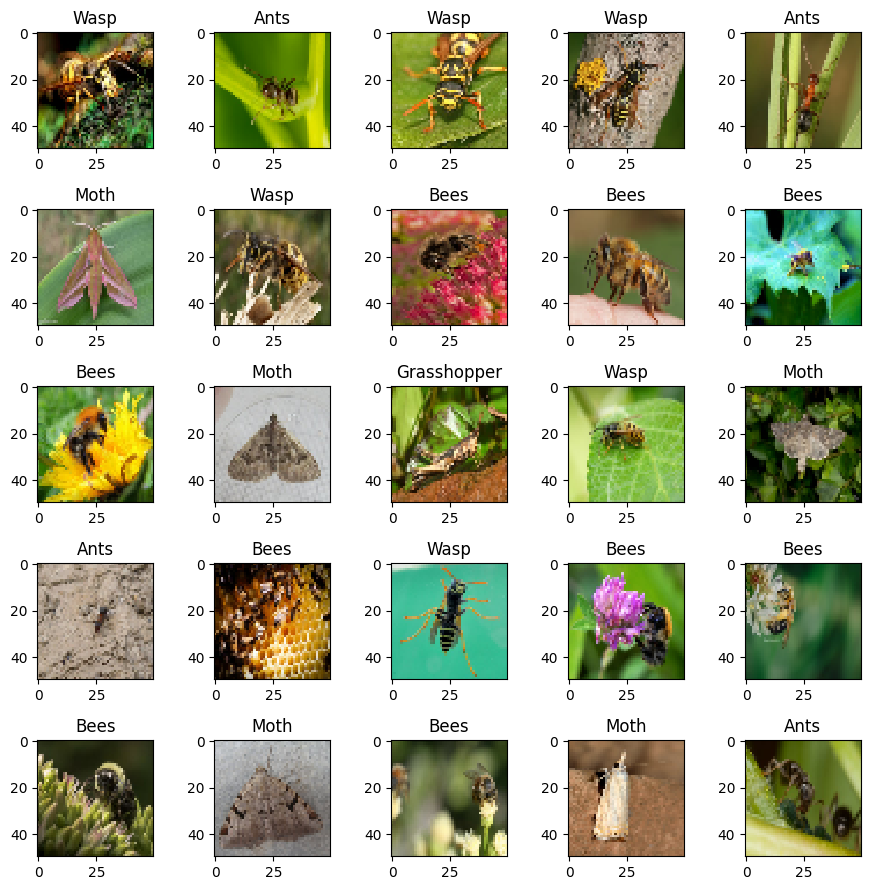

In [7]:
# change the default figure size for all plots created in the program
plt.rcParams['figure.figsize'] = (9,9)

labels =  ['Ants', 'Bees', 'Grasshopper', 'Moth', 'Wasp']

for i in range(25):
    # plt.subplot() function takes three integer arguments: the number of rows, the number of columns, and the index of the subplot.
    plt.subplot(5,5,i+1)
    # plt.imshow() function displays the image at index i in the X_train array as a grayscale image, with no interpolation applied.
    plt.imshow(X_train[i], interpolation='none')
    plt.title("{}".format(labels[int(Y_train[i])]))

plt.tight_layout()

<a id = "cell_model"></a>
## 3. Predictive Modeling

We load the required libraries for CNN construction

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten
from tensorflow.keras.layers import MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, Callback, EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical

The provided below code defines a Convolutional Neural Network (CNN) model using Keras for image classification tasks. The model consists of convolutional layers, max-pooling layers, dropout layers for regularization, and fully connected layers. It's designed to work with 50x50 pixel color images (3 channels) and has an output layer with 5 classes, utilizing `ReLU` activations for hidden layers and softmax for the output layer. The dropout layers help prevent overfitting, and the model's architecture is displayed using the `model.summary()` function.

In [9]:
#CNN model with two Convolution layers, one Pooling layer with max pooling,
#which are stacked on top of a traditional ANN model (with the same architecture as the model 1)
def model_1():
    model = Sequential()
    # This line adds a 2D convolutional layer to the model
    model.add(Conv2D(32, kernel_size=(1, 1),
                     activation='relu',
                     input_shape=(50, 50, 3))) #images with a shape of (50, 50, 3), where 50 is the height and width of the images, and 3 represents the number of color channels
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25)) #adding a dropout layer with a dropout rate of 0.25. Dropout is a regularization technique that helps prevent overfitting
    model.add(Flatten()) #flattening the 2D feature maps into a 1D vector, preparing the data for the fully connected layers.
    model.add(Dense(200, activation='relu')) #adding a fully connected layer with 128 neurons and a ReLU activation function
    model.add(Dropout(0.5)) #adding another dropout layer with a higher dropout rate of 0.5
    model.add(Dense(5, activation='softmax')) #This is the output layer with 5 neurons (5 classes). The softmax activation function is used to obtain probability distributions over the classes.
    model.summary() #displaying information about the layers and the number of parameters in each layer.
    return model

# Define Keras callbacks (when Tensorboard installed) to record training performance
keras_callbacks = [EarlyStopping(monitor='val_loss', patience=20, verbose=0)]

Compile and fit the model using `RMSprop` optimizer.

In [10]:
# convert class vectors to binary class matrices (1 hot coding format)
Y_train_encoded = to_categorical(Y_train, 5)
Y_test_encoded = to_categorical(Y_test, 5)

#Compile and fit the model
model = model_1()
model.compile(loss=categorical_crossentropy,
              optimizer= RMSprop (learning_rate=0.001,weight_decay=1e-6),
              metrics='accuracy')

hist = model.fit(X_train, Y_train_encoded,
      batch_size=128,
      epochs=100,
      verbose=2,
      validation_data=(X_test, Y_test_encoded),
      validation_split=0.2,
      callbacks=keras_callbacks)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        128       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 200)               4000200   
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                        

The training process terminated after 81 epochs.

PERFORMANCE EVALUATION

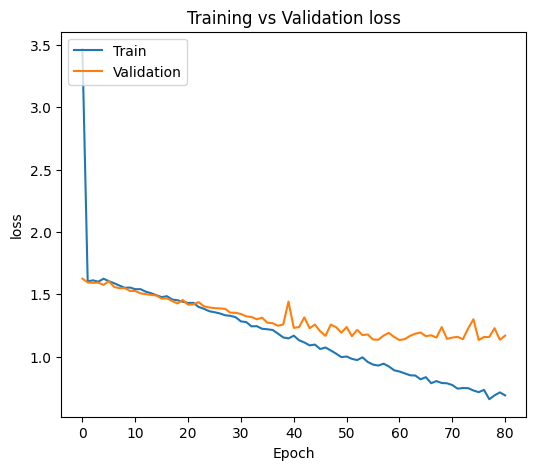

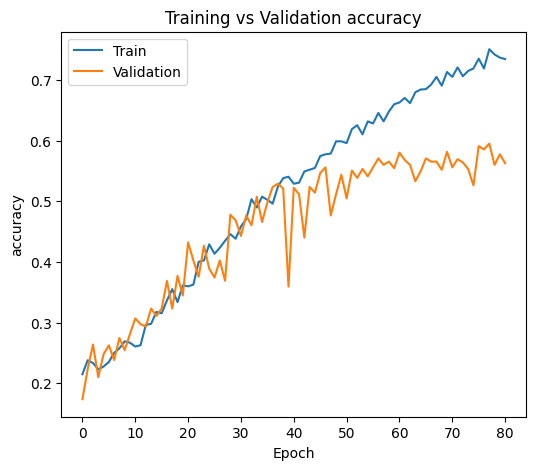

Train loss: 0.4363
Train accuracy: 0.8874 

Test loss: 1.1683
Test accuracy: 0.5626


In [11]:
#Plotting to see how the model is trained based on the the loss and accuracy on training and validation
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]

    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]

    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()
    return

plot_hist(pd.DataFrame(hist.history))

# Evaluate on training data
train_score = model.evaluate(X_train, Y_train_encoded, verbose=0)
print('Train loss:', round(train_score[0], 4))
print('Train accuracy:', round(train_score[1], 4), '\n')

# Evaluate on test data
test_score = model.evaluate(X_test, Y_test_encoded, verbose=0)
print('Test loss:', round(test_score[0], 4))
print('Test accuracy:', round(test_score[1], 4))

The line graphs presenting the training and validation at each espoch for accuracy and mean absolute error (loss).
- For loss graph, when the number of iterations of epoch increases, the further the gap between the training and validation lines, indicating the model is overfitting to the training set.
- Simmilarly to the loss graph, the gap between training and validation lines become further since the epoch increases, indicating the sign of overfitting withing the model.

On the other hand, here's a summary of the results for the training and testing phases of a machine learning or deep learning model:

- Train Loss: The training loss is 0.4363. This metric represents the error or discrepancy between the model's predicted values and the actual target values on the training dataset. A lower training loss indicates that the model has learned to fit the training data well.

- Train Accuracy: The training accuracy is 0.8874, or 88.74%. This metric measures the proportion of correctly classified samples in the training dataset. An accuracy of nearly 89% suggests that the model is performing well on the data it was trained on.

- Test Loss: The testing loss is 1.1683. Similar to the training loss, this metric represents the error or discrepancy between the model's predictions and the actual target values, but it is calculated on a separate, unseen test dataset. A lower test loss indicates that the model generalizes well to new, unseen data.

- Test Accuracy: The testing accuracy is 0.5626, or 56.26%. This metric measures the proportion of correctly classified samples in the test dataset. An accuracy of approximately 56% suggests that the model's performance on new data is moderate but may benefit from further improvements.

In summary, the model appears to perform very well on the training data, achieving a high training accuracy and a relatively low training loss. However, its performance on the test data is not as strong, with a lower test accuracy and a higher test loss. This indicates that the model might be overfitting the training data and may require regularization techniques or other adjustments to improve its generalization to unseen data.

PRESENT THE RESULTS

In [22]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the predicted labels to continuous-multioutput format
y_pred_continuous = np.round(y_pred)

# Convert the predicted labels to multiclass format
y_pred_multiclass = np.argmax(y_pred, axis=1)
y_test_multiclass = np.argmax(Y_test_encoded, axis=1)

# Calculate the kappa score
kappa = cohen_kappa_score(y_test_multiclass, y_pred_multiclass)
print("The result of Kappa is :", round(kappa, 3))

# Generate the classification report
report = classification_report(y_test_multiclass, y_pred_multiclass, target_names= labels)

# Print the report
print("The result of the classification report is: \n ",report) # support is the class of the dataset

24/24 [==============================] - 0s 18ms/step
The result of Kappa is : 0.552
The result of the classification report is: 
                precision    recall  f1-score   support

        Ants       0.61      0.64      0.62       154
        Bees       0.70      0.56      0.62       159
 Grasshopper       0.55      0.46      0.50       140
        Moth       0.75      0.82      0.79       161
        Wasp       0.57      0.71      0.64       129

    accuracy                           0.64       743
   macro avg       0.64      0.64      0.63       743
weighted avg       0.64      0.64      0.64       743



Summary the results:

**Kappa Result (Cohen's Kappa)**:

The Kappa coefficient measures the agreement between the model's predictions and the actual class labels. A Kappa value of 0.552 indicates a moderate level of agreement, suggesting that the model's predictions are better than random chance but may still have room for improvement.

**Classification Report Summary:**

**Accuracy:** The overall accuracy of the model is 64%, meaning it correctly predicts the class labels for 64% of the samples.

**Per-Class Metrics:**
- Moth Class: The model excels in classifying "Moth" with a precision of 0.75, recall of 0.82, and an F1-score of 0.79. These metrics indicate highly accurate and balanced performance for this class.
- Bees Class: "Bees" class exhibits a decent performance with a precision of 0.70 and an F1-score of 0.62, although the recall is slightly lower at 0.56.
- Ants Class: The model performs reasonably well for "Ants" with a precision of 0.61, recall of 0.64, and an F1-score of 0.62.
- Wasp Class: "Wasp" class shows an F1-score of 0.64, indicating a moderate balance between precision (0.57) and recall (0.71).
- Grasshopper Class: "Grasshopper" has lower metrics compared to other classes, with a precision of 0.55, recall of 0.46, and an F1-score of 0.50.

**Macro Average (Macro Avg):** The macro average F1-score is 0.63, reflecting the average performance across all classes without considering class imbalance.

**Weighted Average (Weighted Avg):** The weighted average F1-score is also 0.64, which takes into account class imbalance by weighting the metrics based on the number of samples in each class.

In summary, the model demonstrates moderate to good performance, with varying levels of accuracy and balance across different insect classes. "Moth" is the class with the highest overall performance, while "Grasshopper" has the lowest metrics. These results provide insights into the model's strengths and areas where further optimization may be needed to enhance classification accuracy.

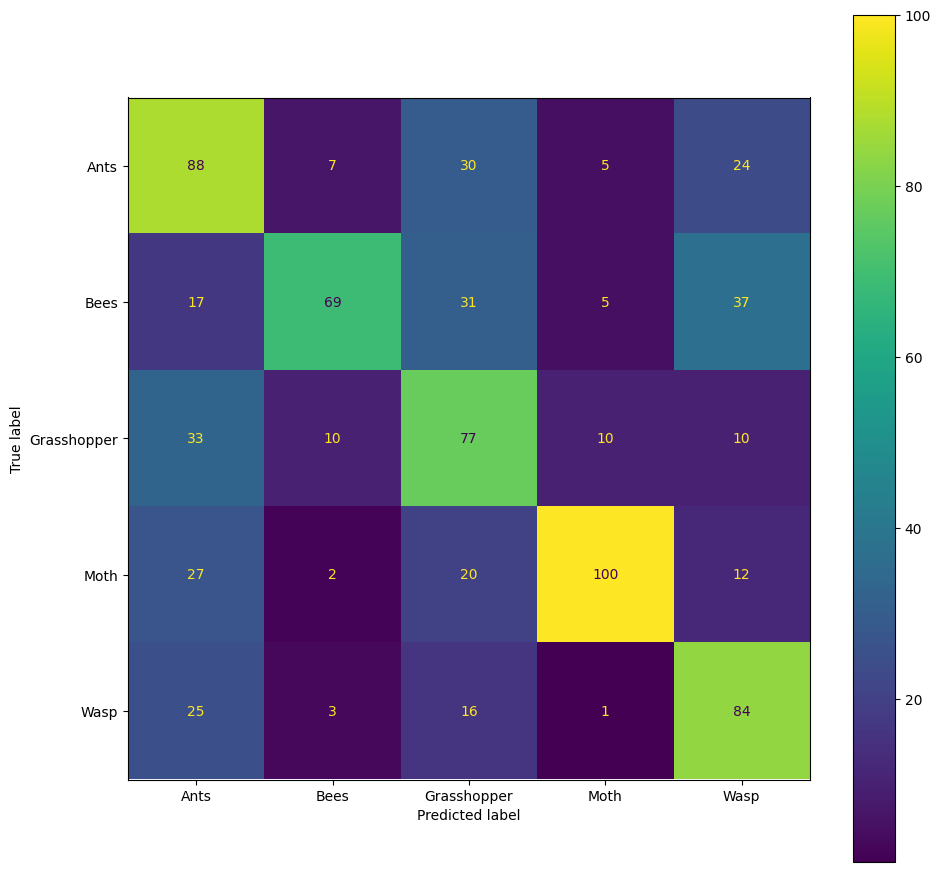

In [13]:
#Compute the confusion matrix with predicted and true labels
cm = confusion_matrix(
    y_test_multiclass,
    y_pred_multiclass)

# Create a ConfusionMatrixDisplay object
display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels)

# Create a figure with a larger size
fig = plt.figure(figsize=(11, 11))

# Create a subplot within the figure
ax = fig.subplots()

# Plot the confusion matrix as a heatmap
display.plot(ax=ax)

# Show the plot
plt.show()

Based on the confusion matrix, it is clearly showed that Moth are the most accurate insect that the model predicted, followed by ants, wasp, grasshopper and bees.
As we can see, the pairs of grasshopper vs. ants, ants vs. wasps are easily mistaken to classify by the model.

PRINT SAMPLE PREDICTIONS FOR INSPECTION

1/1 [==============================] - 0s 31ms/step


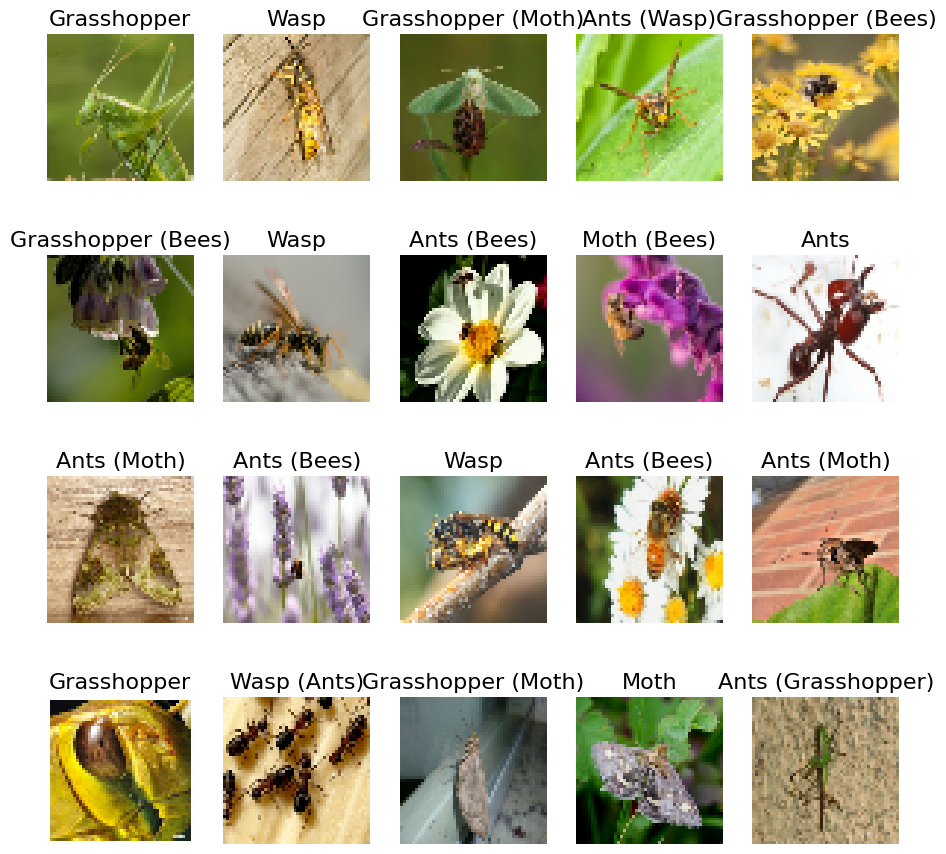

In [14]:
def plot_images(ims, figsize=(12,12), cols=1, interp=False, titles=None): # visualize the image
    if type(ims[0]) is np.ndarray:
        if (ims.shape[-1] != 3):
            ims = ims = ims[:,:,:,0]
    f = plt.figure(figsize=figsize)
    rows=len(ims)//cols if len(ims) % cols == 0 else len(ims)//cols + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

img_range = range(20)
imgs = X_test[img_range]
true_labels = [labels[np.argmax(x)] for x in Y_test_encoded[img_range]]
predictions = model.predict(imgs.reshape(len(img_range), 50, 50, 3))
pred_labels = [labels[np.argmax(x)] for x in predictions]
titles = [pred_labels[x]+('' if true_labels[x] == pred_labels[x] else ' ('+true_labels[x]+')') for x in img_range]
plot_images(imgs, cols=5, figsize=(11,11), titles=titles)

Supporting the confusion matrix results, the sample predictions pointed out the incorrect classification of ants and wasp as well as grasshoppers and ants.

APPLY SECOND BEST MODEL FOR IMAGE CLASSIFICATION

In [23]:
#CNN model with two Convolution layers, one Pooling layer with max pooling, which are stacked on top of a traditional ANN model
def model_2():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(1, 1),
                     activation='relu',
                     input_shape=(50, 50, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(300, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    model.summary()
    return model

# Keras callbacks (when Tensorboard installed)
keras_callbacks = [EarlyStopping(monitor='val_loss', patience=20, verbose=0)]

In [24]:
#Compile and fit model with Adam optimizer
model = model_2()
model.compile(loss=huber,
              optimizer=Adam (learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics='accuracy')

# convert class vectors to binary class matrices (1 hot coding format)
Y_train_encoded = to_categorical(Y_train, 5)
Y_test_encoded = to_categorical(Y_test, 5)

hist = model.fit(X_train, Y_train_encoded,
      batch_size=128,
      epochs=100,
      verbose=2,
      validation_data=(X_test, Y_test_encoded),
      validation_split=0.2,
      callbacks=keras_callbacks)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 50, 50, 32)        128       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 25, 25, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 20000)             0         
                                                                 
 dense_4 (Dense)             (None, 300)               6000300   
                                                                 
 dropout_5 (Dropout)         (None, 300)               0         
                                                      

The training process terminated after 72 epochs.

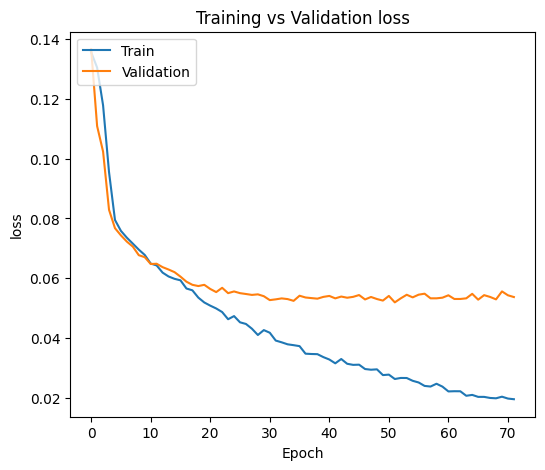

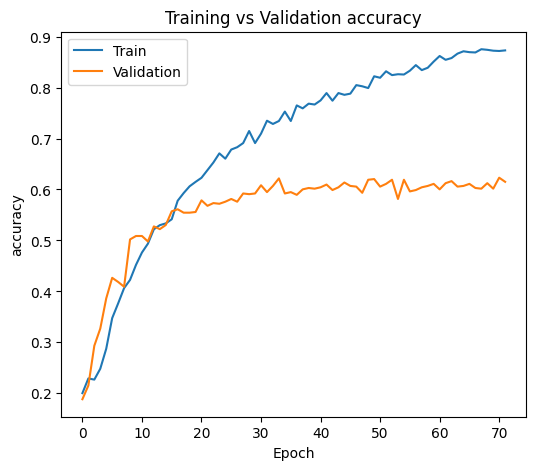

Train loss: 0.0081
Train accuracy: 0.9648 

Test loss: 0.0537
Test accuracy: 0.6151


In [25]:
#Plotting to see how the model is trained based on the the loss and accuracy on training and validation
plot_hist(pd.DataFrame(hist.history))

# Evaluate on training data
train_score = model.evaluate(X_train, Y_train_encoded, verbose=0)
print('Train loss:', round(train_score[0], 4))
print('Train accuracy:', round(train_score[1], 4), '\n')

# Evaluate on test data
test_score = model.evaluate(X_test, Y_test_encoded, verbose=0)
print('Test loss:', round(test_score[0], 4))
print('Test accuracy:', round(test_score[1], 4))

The line graphs presenting the training and validation at each espoch for accuracy and mean absolute error (loss).

For loss graph, when the number of iterations of epoch increases, the further the gap between the training and validation lines. Simmilarly to the loss graph, the gap between training and validation lines become further since the epoch increases.

It seemed that at the 14th epoch onwards, the gap between the training and validation lines become larger after each interation, which indicating the model is overfitting at training dataset.

Considering the loss and accuracy metrics on train and test sets, it can be infered that the model exhibits outstanding performance on the training data, achieving an exceptionally low training loss and a very high training accuracy. However, its performance on the test data is not as strong, with a lower test accuracy compared to the training accuracy.

In [26]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the predicted labels to continuous-multioutput format
y_pred_continuous = np.round(y_pred)

# Convert the predicted labels to multiclass format
y_pred_multiclass = np.argmax(y_pred, axis=1)
y_test_multiclass = np.argmax(Y_test_encoded, axis=1)

# Calculate the kappa score
kappa = cohen_kappa_score(y_test_multiclass, y_pred_multiclass)
print("The result of Kappa is :", round(kappa, 3))

# Generate the classification report
report = classification_report(y_test_multiclass, y_pred_multiclass, target_names= labels)

# Print the report
print("The result of the classification report is: \n ",report) # support is the class of the dataset

24/24 [==============================] - 6s 240ms/step
The result of Kappa is : 0.519
The result of the classification report is: 
                precision    recall  f1-score   support

        Ants       0.54      0.56      0.55       154
        Bees       0.65      0.57      0.61       159
 Grasshopper       0.52      0.52      0.52       140
        Moth       0.75      0.76      0.76       161
        Wasp       0.59      0.66      0.62       129

    accuracy                           0.62       743
   macro avg       0.61      0.61      0.61       743
weighted avg       0.62      0.62      0.62       743



Summary of the results:

**Kappa Result (Cohen's Kappa)**
The Kappa coefficient measures the level of agreement between the model's predictions and the true class labels. In this case, a Kappa value of 0.519 indicates moderate agreement between the model's predictions and the actual labels. It suggests that the model's performance is better than random chance but may still have room for improvement.

**Classification Report:**
The classification report provides a detailed evaluation of the model's performance for each class, as well as overall performance metrics. The per-class metrics reveal variations in the model's performance across different insect classes. "Moth" appears to be the class with the highest overall performance (highest F1-score = 0.76), followed by "Bees" (F1-score = 0.61) and "Wasp" (F1-Score = 0.62). "Ants" (F1-score = 0.55) and "Grasshopper" classes show lower performance, with "Grasshopper" being the weakest (lowest F1 score = 0.52).

**Accuracy:** The overall accuracy of the model is 62%. This means that the model correctly predicts the class labels for 62% of the samples.

**Macro Average (Macro Avg)**: The macro average is the average of precision, recall, and F1-score across all classes, giving equal weight to each class. In this case, the macro average F1-score is 0.61, indicating a moderate overall performance.

**Weighted Average (Weighted Avg)**: The weighted average is similar to the macro average but takes into account class imbalance by weighting the metrics based on the number of samples in each class. In this case, the weighted average F1-score is 0.62, slightly higher than the macro average due to class imbalance.

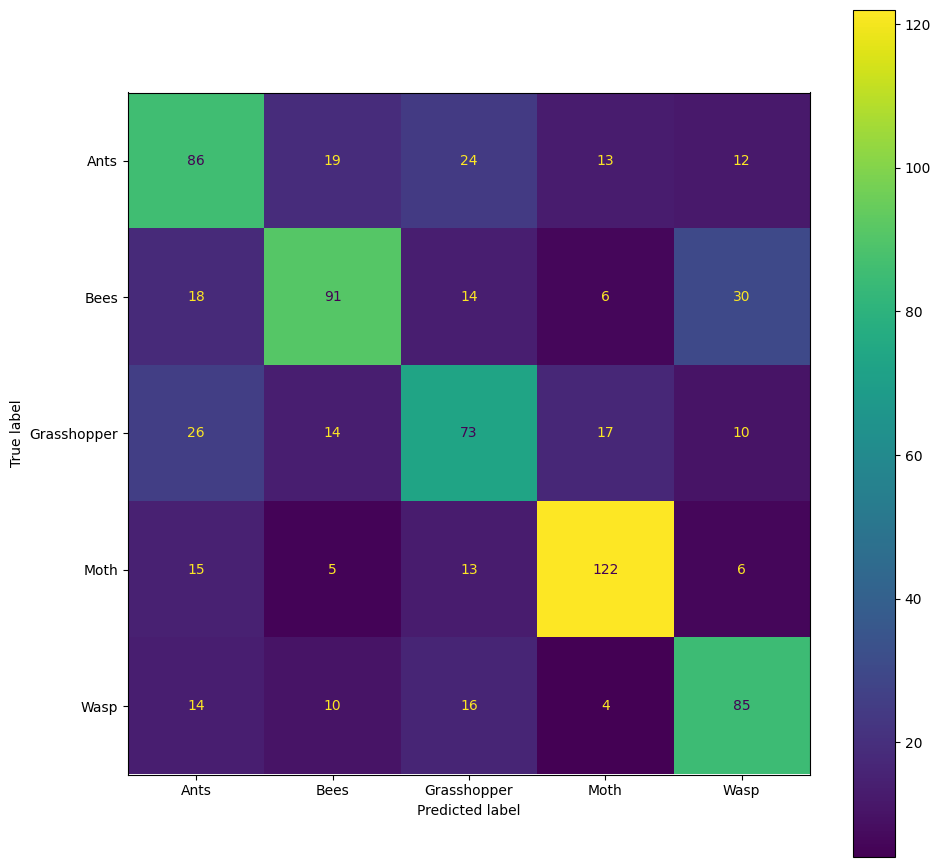

In [29]:
#Compute the confusion matrix with predicted and true labels
cm = confusion_matrix(
    y_test_multiclass,
    y_pred_multiclass)

# Create a ConfusionMatrixDisplay object
display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels)

# Create a figure with a larger size
fig = plt.figure(figsize=(11, 11))

# Create a subplot within the figure
ax = fig.subplots()

# Plot the confusion matrix as a heatmap
display.plot(ax=ax)

# Show the plot
plt.show()

Based on the confusion matrix, it is clearly showed that Moth are the most accurate insect that the model predicted, followed by bees, wasp, ants and grasshopper.

As we can see, the bees and wasps are easily mistaken to classify for the model with 30 wrong image recognition between 2 classes.

On the other hand, the model seems to make less accurate on predicting ants and grasshoppers with high values of wrong prediction on true labels between these 2 classes.

PLOT SAMPLE PREDICTIONS

1/1 [==============================] - 0s 210ms/step


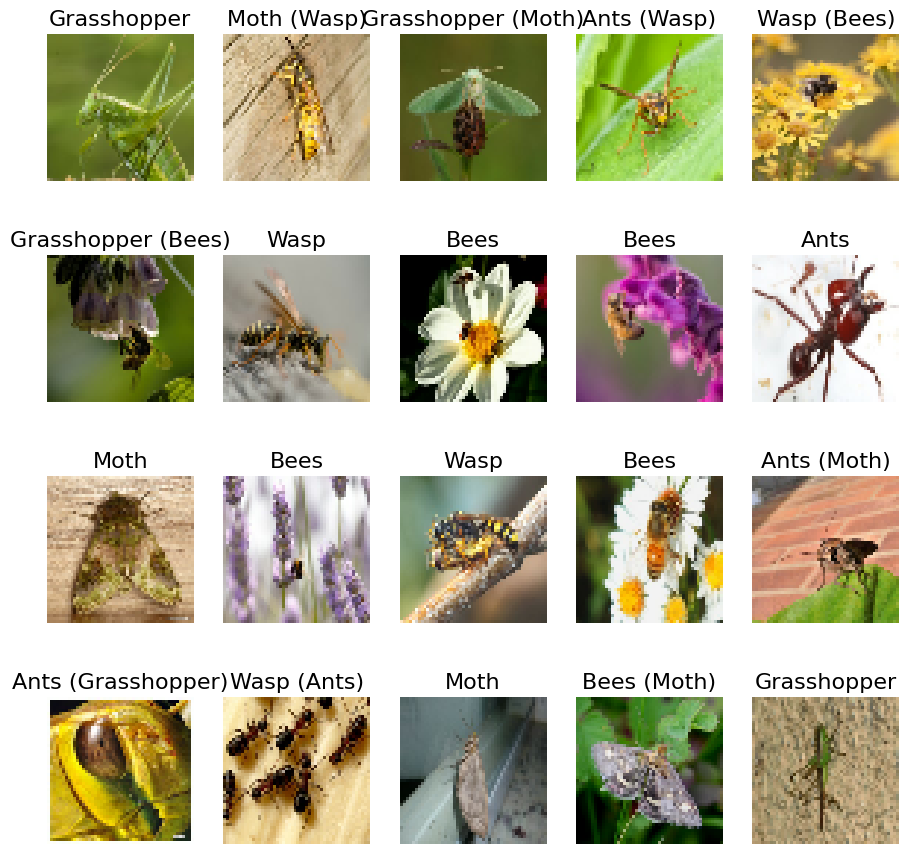

In [30]:
img_range = range(20)
imgs = X_test[img_range]
true_labels = [labels[np.argmax(x)] for x in Y_test_encoded[img_range]]
predictions = model.predict(imgs.reshape(len(img_range), 50, 50, 3))
pred_labels = [labels[np.argmax(x)] for x in predictions]
titles = [pred_labels[x]+('' if true_labels[x] == pred_labels[x] else ' ('+true_labels[x]+')') for x in img_range]
plot_images(imgs, cols=5, figsize=(11,11), titles=titles)

The prediction samples also support the confusion matrix results in pointing out the incorrect classfication of ants and grasshopper as well as predicting wasps as bees.

**COMPARING THE 2 MODELS**

Let's compare and discuss the two models (Model 1 and Model 2) based on the provided results:

**Model 1:**
- Kappa Result: 0.552
- Overall Accuracy: 64%
- Macro Average F1-Score: 0.63
- Weighted Average F1-Score: 0.64


**Model 2:**

- Kappa Result: 0.519
- Overall Accuracy: 62%
- Macro Average F1-Score: 0.61
- Weighted Average F1-Score: 0.62

Comparison and Discussion:

1. Kappa Result:

Model 1 achieved a higher Kappa result of 0.552 compared to Model 2, which had a Kappa result of 0.519. This suggests that Model 1 exhibits a slightly better level of agreement between its predictions and the true class labels compared to Model 2.

2. Overall Accuracy:

Model 1 achieved a higher overall accuracy of 64%, while Model 2 had an accuracy of 62%. Model 1 outperformed Model 2 in terms of correctly classifying samples in the test dataset.

3. F1-Scores:

When examining the F1-scores, which provide a balance between precision and recall, Model 1 generally achieved higher F1-scores across the different classes compared to Model 2. This indicates that Model 1 has a better trade-off between precision and recall for most classes.

4. Per-class metrics:

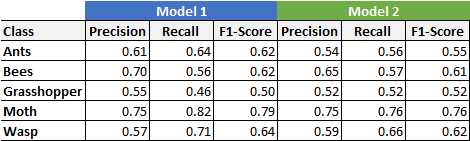

- Ants Class:

Model 1 has a slightly higher precision, recall, and F1-Score for the "Ants" class compared to Model 2. This indicates that Model 1 is better at correctly classifying "Ants" instances while maintaining a good balance between precision and recall.

- Bees Class:

Model 1 achieves a higher precision for the "Bees" class, while Model 2 has a slightly higher recall. However, their F1-Scores are similar. Model 1 may have a slight advantage in terms of precision.

- Grasshopper Class:

Both models have nearly identical precision, recall, and F1-Score values for the "Grasshopper" class. Their performance in this class is quite similar.

- Moth Class:

Model 1 and Model 2 both excel in the "Moth" class, with high precision, recall, and F1-Score values. There is no significant difference between the models in this class.

- Wasp Class:

Model 2 has a slightly higher precision for the "Wasp" class, while Model 1 achieves a slightly higher recall. Their F1-Scores are similar. Model 1 may have a slight advantage in terms of recall.


In summary, Model 1 appears to be the stronger of the two models based on the provided results. It achieved a higher Kappa coefficient, higher overall accuracy, and generally higher F1-scores. Regaring deeper into each class, Model 1 generally exhibits slightly better or similar per-class metrics compared to Model 2 for most classes. It achieves higher precision, recall, and F1-Score values in several cases. However, the differences are relatively modest, and both models have strengths and weaknesses across different classes.






<a id = "cell_report"></a>
## 4. Experiments Report

Beside the 2 models, different experiments have been conducted to achieve the best result of accuracy, kappy as well as F1-score according to the changes in:
- Hyperparameters: filters, dense layers, kernel size
- Quality of images
- Optimizer: RMSprop, Adam, Adadelta
- Loss function: categorical_crossentropy, huber

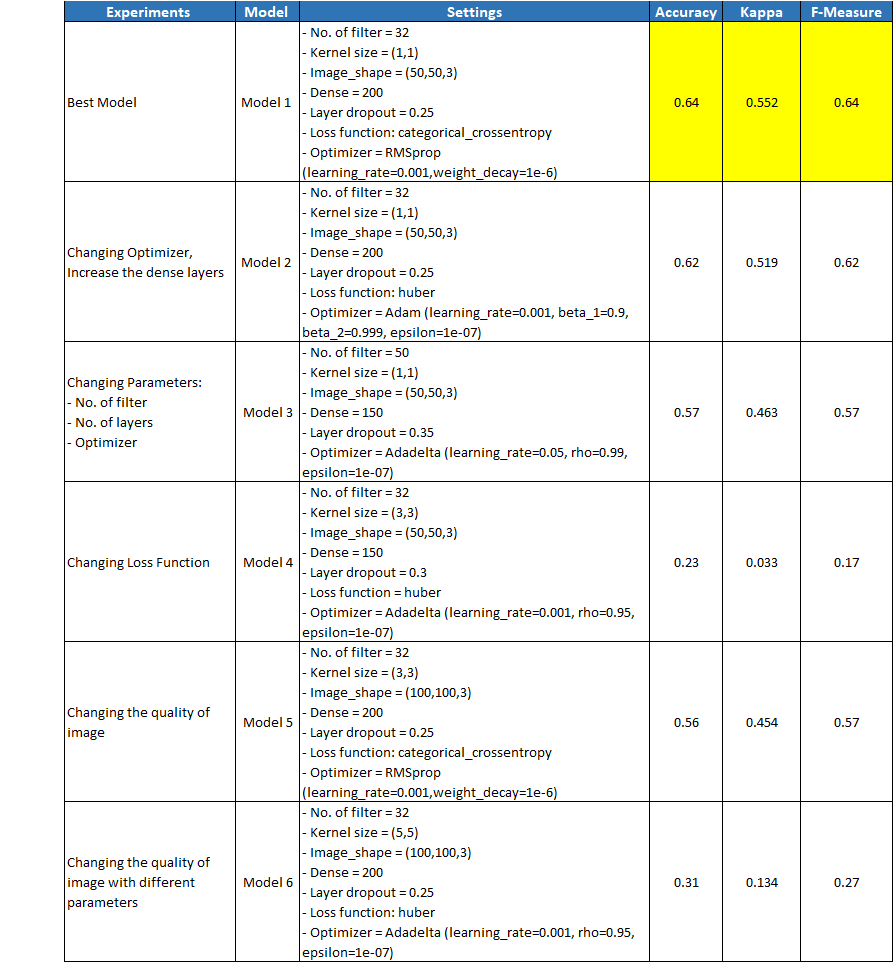

**Impact of Each Setting:**

- *Number of Filters* (32): The number of filters in the convolutional layers determines the capacity of the model to capture features from the input images.
In these experiments: filters = 32, 50 have been tested. In this case, 32 filters appear to be sufficient for the task, as increasing the number of filters did not necessarily lead to improved performance. Too many filters can increase model complexity and the risk of overfitting.

- *Kernel Size* (1,1): The choice of a kernel size of (1,1) means that the model performs a pointwise convolution, essentially acting as a fully connected layer. This setting allows the model to learn fine-grained patterns in the data.
In these experiments: kernel size of (1,1), (3,3), and (5,5) have been tested
For this specific task, it seems to work well on the lowest kernel.

- *Image Shape* (50,50,3): The image shape impacts the resolution and amount of information the model can process. A (50,50,3) shape is relatively small, which helps keep the model computationally efficient. However, it's important to ensure that this resolution is sufficient to capture relevant features from the images.
The image size of (50,50,3) and (100,100,3) have been tested and the better results lean toward smaller image size within this model, plus with it was more time efficient to train the model.

- *Dense* (200): The dense layer with 200 units is placed after flattening the feature maps from the convolutional layers. It allows the model to learn high-level abstractions from the features extracted by the convolutional layers. The higher of the layers will help to capture the features of each image yet will retain the overfitting issue. The choice of 200 units among [150,200, 250] seems suitable for this task, but further experimentation could optimize this parameter.

- *Layer Dropout* (0.25): Dropout is a regularization technique that helps prevent overfitting. A dropout rate of 0.25 means that during training, 25% of the neurons in the dropout layer are randomly set to zero, reducing over-reliance on specific neurons. This setting strikes a balance between regularization and model capacity.

- *Loss Function* (Categorical Cross-Entropy): Categorical Cross-Entropy is a common choice for multi-class classification tasks. It measures the dissimilarity between predicted probabilities and actual class labels. Beside the huber loss function was applied to test the results, yet this loss function encourages the model to make confident predictions and penalizes large errors, is more appropriate.  

- *Optimizer* (RMSprop): RMSprop is an adaptive learning rate optimization algorithm. The specific learning rate (0.001) and weight decay (1e-6) settings help control the convergence of the model. These hyperparameters contribute to the model's stability during training. Together with RMSprop, Adam and Adadelta are also applied but RMSprop seemed to be a better fit for the model.

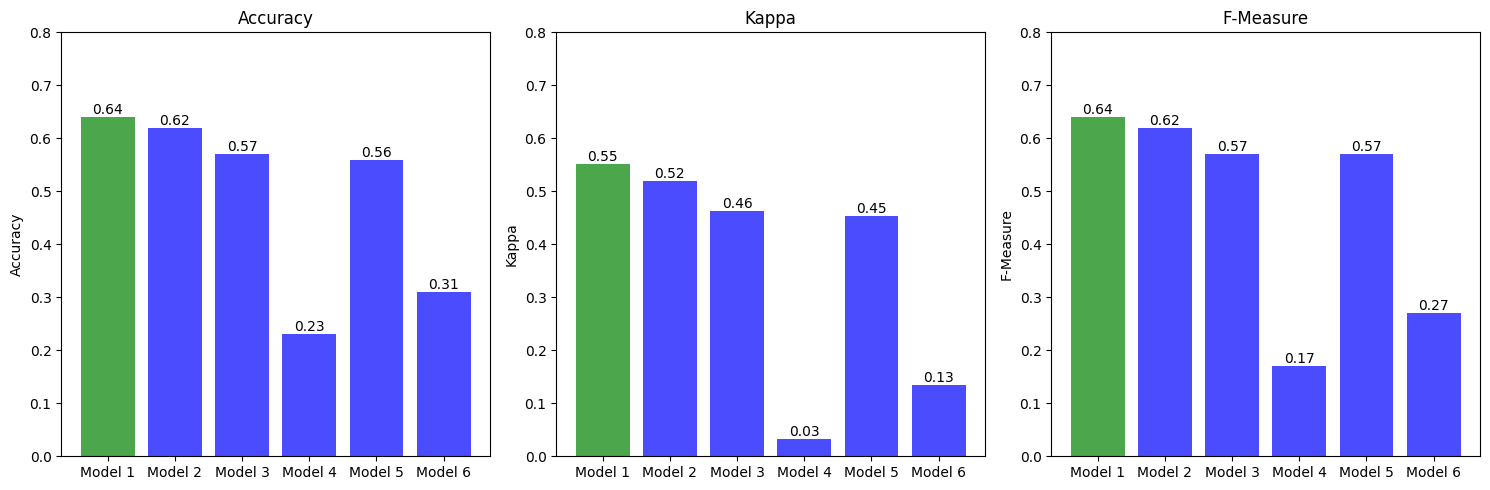

In [34]:
# Define the model names and corresponding metric values
model_names = ["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6"]
accuracy_values = [0.64, 0.62, 0.57, 0.23, 0.56, 0.31]
kappa_values = [0.552, 0.519, 0.463, 0.033, 0.454, 0.134]
f_measure_values = [0.64, 0.62, 0.57, 0.17, 0.57, 0.27]

# Create subplots for each metric
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot accuracy
ax1.bar(model_names, accuracy_values, color=['g' if model == "Model 1" else 'b' for model in model_names], alpha=0.7)
ax1.set_ylim([0, 0.8])
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy')
for i, value in enumerate(accuracy_values):
    ax1.text(i, value, f'{value:.2f}', ha='center', va='bottom')

# Plot kappa
ax2.bar(model_names, kappa_values, color=['g' if model == "Model 1" else 'b' for model in model_names], alpha=0.7)
ax2.set_ylim([0, 0.8])
ax2.set_ylabel('Kappa')
ax2.set_title('Kappa')
for i, value in enumerate(kappa_values):
    ax2.text(i, value, f'{value:.2f}', ha='center', va='bottom')

# Plot F-measure
ax3.bar(model_names, f_measure_values, color=['g' if model == "Model 1" else 'b' for model in model_names], alpha=0.7)
ax3.set_ylim([0, 0.8])
ax3.set_ylabel('F-Measure')
ax3.set_title('F-Measure')
for i, value in enumerate(f_measure_values):
    ax3.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Based on the visualized graphs:

Model 1 outperforms all other models in terms of accuracy, Kappa, and F1-Score.
- It achieves the highest accuracy (64%) compared to the other models, indicating that it correctly classifies a significant portion of test samples.
- The Kappa coefficient of 0.552 indicates substantial agreement between predictions and true labels, showing strong model performance.
- The F1-Score of 0.64, which is a balance between precision and recall, demonstrates that Model 1 maintains a good trade-off between minimizing false positives and false negatives.

Improving the performance of pest recognition models for real-world deployment in agricultural settings is crucial for ensuring effective pest management and crop protection. Here are some potential approaches to enhance the performance of these models:

1. **High-Quality Data Collection:**
Diverse and Representative Data: Collect a diverse dataset that includes various crop types, growth stages, lighting conditions, and pest species to ensure the model's robustness.
2. **Accurate Annotations**: Ensure accurate labeling of pest instances in the dataset to train the model effectively.
3. **Data Augmentation:**
Apply data augmentation techniques like rotation, scaling, cropping, and flipping to artificially increase the amount of training data, reducing overfitting.
4. **Preprocessing:**
Noise Reduction: Remove noise from images through techniques like image denoising and background subtraction.
Image Enhancement: Enhance image quality by adjusting contrast, brightness, and sharpness to improve model performance.

5. **Data Balancing:** Address class imbalance issues by oversampling minority classes or using techniques like focal loss to give more weight to difficult-to-detect pests.

6. **Continuous Monitoring**:
Implement continuous monitoring systems that regularly update models with new data to adapt to changing pest populations and environmental conditions.

7. **Evaluation and Iteration**:Continuously evaluate model performance in real-world agricultural settings and iterate on model improvements based on feedback and new data.

Improving pest recognition models for agriculture is an ongoing process that requires a combination of data, technology, and domain knowledge. By employing these approaches and staying responsive to the evolving needs of the agricultural industry, it is possible to develop more accurate and effective pest recognition systems for real-world deployment.